# MLP
Experiments using MLP classifier to try and classify coughs as covid postive vs covid negative.

By settings random_state to some common value for both Mel Spectrogram and MFCC randomised search cross-val, we can ensure that both approaches are tested on the same architectures. This allows for better comparison between Mel Spectogram and MFCC for each model, whilst still enabling each model type to be compared.

## Installing Required Packages and Setting Random State

In [1]:
# standard imports
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt 
from scipy import stats

# for creating representative sample of whole dataset
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import imblearn
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

# librosa and sklearn for pre-processing and cross validation
import librosa
from sklearn import preprocessing, model_selection

# import model
from xgboost import XGBClassifier

# visualisations
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
import librosa.display
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
random_state = 23

## Sample Creation

In [3]:
# load metadata csv
metadata = pd.read_csv("coughvid-19/metadata_compiled.csv")

# select relevant columns for resampling later
metadata = metadata[['uuid', 'cough_detected', 'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status']]

# basic filtering
metadata = metadata[metadata['cough_detected'] >= 0.8]  # recommendation by dataset creators
metadata = metadata[metadata['status'] != 'symptomatic']  # no way of knowing whether symptomatic == covid positive or negative
metadata = metadata[metadata['status'].notna()] 
metadata.drop(columns=['cough_detected'], inplace=True) 

# fill in nulls with mean of stratum (only present in age column)
metadata["age"] = metadata.groupby(["gender", "respiratory_condition", "fever_muscle_pain"]).transform(lambda x: x.fillna(x.mean()))
# split age into bands for better stratified sampling
metadata.age = pd.cut(metadata.age, bins=10)

print("Class distribution before resampling")
print(metadata.status.value_counts())

metadata.head()

Class distribution before resampling
healthy     8300
COVID-19     699
Name: status, dtype: int64


,uuid,age,gender,respiratory_condition,fever_muscle_pain,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,"(10.8, 20.6]",male,False,False,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,"(30.4, 40.2]",male,True,False,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,"(20.6, 30.4]",male,False,False,healthy
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,"(20.6, 30.4]",female,False,False,healthy
11,00291cce-36a0-4a29-9e2d-c1d96ca17242,"(10.8, 20.6]",male,False,False,healthy


In [4]:
# split out positive and negative records to ensure all positive records are kept for training and testing
metadata_pos = metadata[metadata['status']=='COVID-19']
metadata_neg = metadata[metadata['status']=='healthy']

metadata_pos = metadata_pos.reset_index().drop(columns='index')
metadata_neg = metadata_neg.reset_index().drop(columns='index')

In [5]:
X_neg = metadata_neg.drop(columns=['status', 'uuid'])
y_neg = metadata_neg.status

overall_sample_size = 2500  # balance between training time, and ensuring that resampling doesn't create bias
n_positive = len(metadata_pos)

# create smaller sample of original data set
sss = StratifiedShuffleSplit(n_splits=1, test_size=(2500-n_positive)/len(y_neg), random_state=random_state)
splits = sss.split(X_neg, y_neg)
for i in splits:
    experiment_set_ind = i[1]

print(f"First 10 indeces in sample: {experiment_set_ind[:10]}\n")  # first 10 indices

negative_uuids = metadata_neg.uuid.values[experiment_set_ind]  # stratified sample of negative uuids n=2500-699
positive_uuids = metadata_pos.uuid.values 

First 10 indeces in sample: [8057 3985 5852 6820 6964 6854 2372 2792 3662 7901]



In [6]:
# select negative sample using uuids
metadata_reduced_negative = metadata[metadata['uuid'].isin(negative_uuids)]
# select positive sample using uuids
metadata_reduced_positive = metadata[metadata['uuid'].isin(positive_uuids)]

# separate out target
X_negative = metadata_reduced_negative[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_negative = metadata_reduced_negative['status']
X_positive = metadata_reduced_positive[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_positive = metadata_reduced_positive['status']

# aim to maximize number of positive cases in training data
# keep 50 in testing data
X_train_n, X_test_n , y_train_n, y_test_n = train_test_split(X_negative, y_negative, test_size=0.2495, random_state=random_state)
X_train_p, X_test_p , y_train_p, y_test_p = train_test_split(X_positive, y_positive, test_size=0.071, random_state=random_state)

X_train, y_train = pd.concat([X_train_p, X_train_n]), pd.concat([y_train_p, y_train_n])
X_test, y_test = pd.concat([X_test_p, X_test_n]), pd.concat([y_test_p, y_test_n])

print("Training set class balance BEFORE resampling:")
print(y_train.value_counts(), "\n")

print("Test set class balance BEFORE resampling:")
print(y_test.value_counts())


Training set class balance BEFORE resampling:
healthy     1351
COVID-19     649
Name: status, dtype: int64 

Test set class balance BEFORE resampling:
healthy     450
COVID-19     50
Name: status, dtype: int64


In [7]:
# balance the training set (and create balanced test set for optional use later)
# use recommended SMOTE methodology
oversample = imblearn.over_sampling.SMOTEN(sampling_strategy=1000/1351, random_state = random_state)  # desired_n/size of majority
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = random_state)
steps = [('o', oversample), ('u', undersample)]
rebalancing_pipeline = Pipeline(steps=steps)

X_train, y_train = rebalancing_pipeline.fit_resample(X_train, y_train)

print("Training set class balance AFTER resampling: ")
print(y_train.value_counts(), "\n")

Training set class balance AFTER resampling: 
COVID-19    1000
healthy     1000
Name: status, dtype: int64 



In [8]:
## create list of uuids
X_train_uuids = X_train.uuid.values
X_test_uuids = X_test.uuid.values

print(f"Re-balanced sample has {len(X_train_uuids) + len(y_test)} records from {len(positive_uuids) + len(negative_uuids)} originally.")

Re-balanced sample has 2500 records from 2500 originally.


## Load and Transform Data

In [9]:
# Load the data

PATH_TO_AUDIO = 'wav_recordings/'

def create_ds(uuid_list, audio_folder):
    """
    Returns: pandas dataframe; 
    Each dataframe has 3 columns - raw audio signal, sample rate, label (covid vs not covid)
    """
    signals = []
    labels = np.array([])
    input_len = 10*22050  # need to find justifiable length, also consider downsampling!

    for uuid in uuid_list:
        signal, _ = librosa.load(f'{audio_folder}{uuid}.wav')
        label = metadata[metadata['uuid'] == uuid]['status'].values[0]

        #signal = down_samp(signal)  # not a function (yet?)
        signal = signal[:input_len]
        zero_padding = np.zeros(input_len-len(signal))
        signal = np.append(signal, zero_padding)

        signals.append(signal)
        labels = np.append(labels, label)

    #ds = pd.DataFrame(data = data, columns=['audio', 'sample_rate', 'label'])

    return np.array(signals), labels


sample_rate = 22050.0  # checked all recordings so lets save some memory and time

train_signals, y_train = create_ds(X_train_uuids, PATH_TO_AUDIO)
test_signals, y_test = create_ds(X_test_uuids, PATH_TO_AUDIO)


In [10]:
# shuffle data (is ordered during rebalancing)
train_signals, y_train = shuffle(train_signals, y_train, random_state=random_state)
test_signals, y_test = shuffle(test_signals, y_test, random_state=random_state)

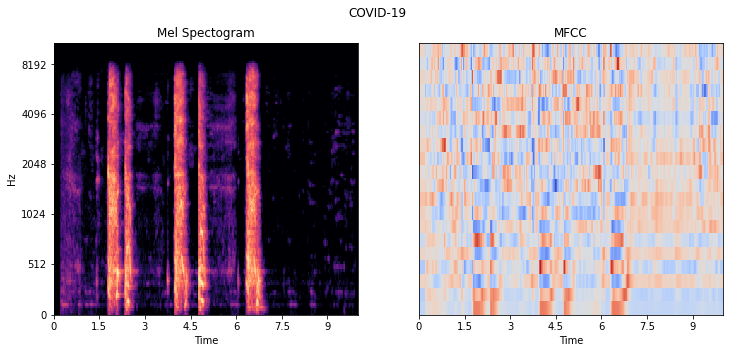

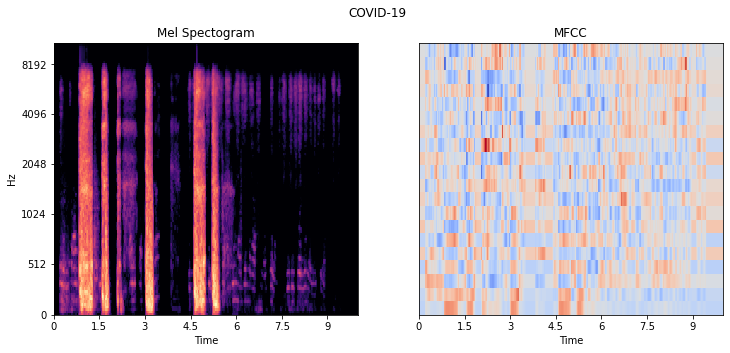

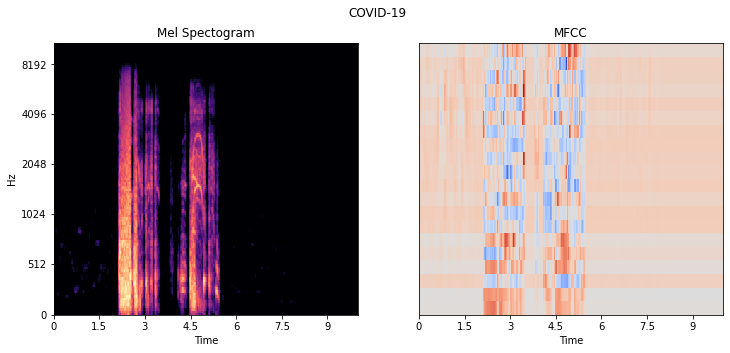

In [11]:
def get_mel_spectrogram(signal):
    sgram =librosa.stft(signal)

    sgram_mag, _= librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag)

    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref = np.min)

    return mel_sgram

def get_mfcc(signal, n_mfcc=20):
    """
        Return mfcc with x mfccs
    """
    mfcc = librosa.feature.mfcc(signal, n_mfcc=n_mfcc)
    mfcc = preprocessing.scale(mfcc, axis=1)
    return mfcc

# plot 3 mel spectograms to show that helper function works
for a in range(3):
    i = random.randint(0, len(train_signals))
    mel_sgram = get_mel_spectrogram(train_signals[i])
    mfcc = get_mfcc(train_signals[i])


    label = y_train[i]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    librosa.display.specshow(mel_sgram, x_axis='time', y_axis='mel', ax=ax1)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax2)


    fig.suptitle(label)
    ax1.set_title('Mel Spectogram')
    ax2.set_title('MFCC')
    #plt.colorbar(format='%+2.0f dB', ax=ax1)
    plt.show()



In [12]:
train_mel_spectrograms = []
test_mel_spectrograms = []

train_mfccs = []
test_mfccs = []

for signal in train_signals:
    mel_spect = get_mel_spectrogram(signal)
    train_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc(signal)
    train_mfccs.append(mfcc)


for signal in test_signals:
    mel_spect = get_mel_spectrogram(signal)
    test_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc(signal)
    test_mfccs.append(mfcc)

train_mel_spectrograms = np.array(train_mel_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
test_mfccs = np.array(test_mfccs)

# normalise (between 0 and 1)
train_mel_spectrograms = (train_mel_spectrograms - train_mel_spectrograms.min())/(train_mel_spectrograms.max() - train_mel_spectrograms.min())
test_mel_spectrograms = (test_mel_spectrograms - test_mel_spectrograms.min())/(test_mel_spectrograms.max() - test_mel_spectrograms.min())
train_mfccs = (train_mfccs - train_mfccs.min())/(train_mfccs.max() - train_mfccs.min())
test_mfccs = (test_mfccs - test_mfccs.min())/(test_mfccs.max() - test_mfccs.min())


In [13]:
#pre-process labels
def to_binary(label):
    if label == 'COVID-19':
        return 1
    else:
        return 0

y_train = np.array(list(map(to_binary, y_train)))
y_test = np.array(list(map(to_binary, y_test)))


In [14]:
train_mfccs.shape, test_mfccs.shape

((2000, 20, 431), (500, 20, 431))

## Mel Spectogram 

In [15]:
X_train = train_mel_spectrograms
X_test = test_mel_spectrograms
# reshape for XGBoost model (only takes vector inputs)
X_train = X_train.reshape(2000, 128*431)
X_test = X_test.reshape(500, 128*431)

In [16]:
model = XGBClassifier()

### Base Model

In [27]:
param_dist = {
    'n_estimators' : stats.randint(170, 350),
    'max_depth' : stats.randint(10, 25),
    'gamma' : stats.uniform(0, 2),
    'min_child_weight' : stats.randint(3, 8)
}

rnd_search_cv = model_selection.RandomizedSearchCV(model, param_dist, n_iter = 5, cv=5, scoring=['roc_auc', 'recall'],
                refit = 'roc_auc',random_state = random_state, return_train_score=True)
rnd_search_cv.fit(X_train, y_train)

[11:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:07:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:20] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1d0b86710>,
                                        'max_depth': <scipy.

In [28]:
rnd_search_cv.best_params_

{'gamma': 0.1996402351922164,
 'max_depth': 21,
 'min_child_weight': 7,
 'n_estimators': 219}

In [18]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([378.49256063]),
 'std_fit_time': array([29.1557289]),
 'mean_score_time': array([0.19501095]),
 'std_score_time': array([0.01289413]),
 'param_n_estimators': masked_array(data=[219],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[21],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.19964],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 219,
   'min_child_weight': 7,
   'max_depth': 21,
   'gamma': 0.19964}],
 'split0_test_roc_auc': array([0.733475]),
 'split1_test_roc_auc': array([0.749125]),
 'split2_test_roc_auc': array([0.747225]),
 'split3_test_roc_auc': array([0.74835]),
 'split4_test_roc_auc': array([0.74975]),
 'mean_test_roc_a

### Fine tune model

In [30]:
param_dist = {
    'n_estimators' : stats.randint(200, 250),
    'max_depth' : stats.randint(17, 25),
    'gamma' : stats.uniform(0, 0.5),
    'min_child_weight' : stats.randint(5, 8)
}

rnd_search_cv_2 = model_selection.RandomizedSearchCV(model, param_dist, n_iter = 5, cv=5, scoring=['roc_auc', 'recall'],
                refit = 'roc_auc',random_state = random_state, return_train_score=True)
rnd_search_cv_2.fit(X_train, y_train)

[16:26:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:13] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa0c8141c90>,
                                        'max_depth': <scipy.

In [31]:
rnd_search_cv_2.best_params_

{'gamma': 0.0499100587980541,
 'max_depth': 20,
 'min_child_weight': 6,
 'n_estimators': 212}

In [21]:
rnd_search_cv_2.cv_results_

{'mean_fit_time': array([360.1175036]),
 'std_fit_time': array([9.20634777]),
 'mean_score_time': array([0.20351081]),
 'std_score_time': array([0.01346953]),
 'param_n_estimators': masked_array(data=[212],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[6],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.04991],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 212,
   'min_child_weight': 6,
   'max_depth': 20,
   'gamma': 0.04991}],
 'split0_test_roc_auc': array([0.743975]),
 'split1_test_roc_auc': array([0.7901]),
 'split2_test_roc_auc': array([0.76625]),
 'split3_test_roc_auc': array([0.749925]),
 'split4_test_roc_auc': array([0.756275]),
 'mean_test_roc_auc

#### Evaluate performance of fine-tuned model

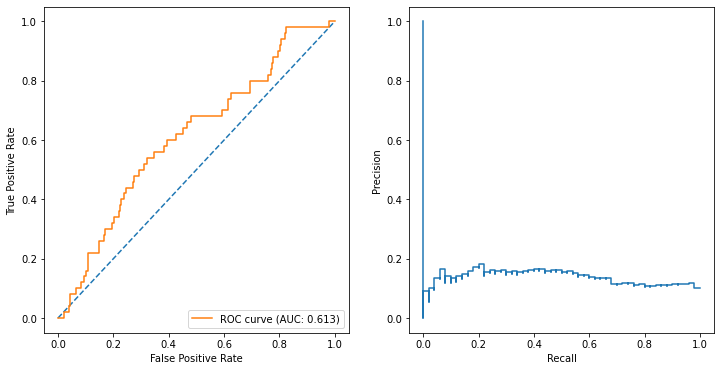

              precision    recall  f1-score   support

           0      0.922     0.760     0.833       450
           1      0.163     0.420     0.235        50

    accuracy                          0.726       500
   macro avg      0.542     0.590     0.534       500
weighted avg      0.846     0.726     0.773       500



[]

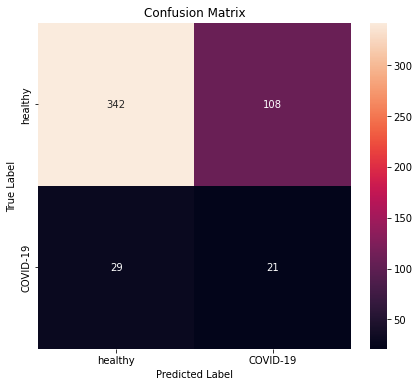

In [32]:
# choose best model from cv run
cv_model_2 = rnd_search_cv_2.best_estimator_

# make predictions on test data
y_test_pred = cv_model_2.predict(X_test)
y_test_probs = cv_model_2.predict_proba(X_test)[:,1]

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC: {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot()

## MFCCs

In [16]:
train_mfccs.shape

(2000, 20, 431)

In [17]:
X_train = train_mfccs
X_test = test_mfccs
# reshape for XGBoost model (only takes vector inputs)
X_train = X_train.reshape(2000, 20*431)
X_test = X_test.reshape(500, 20*431)

In [18]:
model = XGBClassifier()

### Base Model

In [103]:
param_dist = {
    'n_estimators' : stats.randint(20, 400),
    'max_depth' : stats.randint(1, 20),
    'gamma' : stats.uniform(0, 9),
    'min_child_weight' : stats.randint(0, 10)
}

rnd_search_cv_1 = model_selection.RandomizedSearchCV(model, param_dist, n_iter = 12, cv=5, scoring = ['roc_auc', 'recall'], 
                refit = 'roc_auc',random_state = random_state, return_train_score=True)
rnd_search_cv_1.fit(X_train, y_train)

[22:09:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:09:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:09:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:15] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc840457ed0>,
                                        'max_depth': <scipy.

In [106]:
rnd_search_cv_1.best_params_

{'gamma': 1.4581123110247405,
 'max_depth': 19,
 'min_child_weight': 5,
 'n_estimators': 303}

In [20]:
rnd_search_cv_1.cv_results_

{'mean_fit_time': array([94.36418433]),
 'std_fit_time': array([2.11071447]),
 'mean_score_time': array([0.05106258]),
 'std_score_time': array([0.00919882]),
 'param_n_estimators': masked_array(data=[303],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[19],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1.4581],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 303,
   'min_child_weight': 5,
   'max_depth': 19,
   'gamma': 1.4581}],
 'split0_test_roc_auc': array([0.761825]),
 'split1_test_roc_auc': array([0.752325]),
 'split2_test_roc_auc': array([0.7347]),
 'split3_test_roc_auc': array([0.68095]),
 'split4_test_roc_auc': array([0.7243]),
 'mean_test_roc_auc': a

### Fine tune base model

In [19]:
param_dist = {
    'n_estimators' : stats.randint(170, 350),
    'max_depth' : stats.randint(10, 25),
    'gamma' : stats.uniform(0, 2),
    'min_child_weight' : stats.randint(3, 8)
}

rnd_search_cv_2 = model_selection.RandomizedSearchCV(model, param_dist, n_iter = 12, cv=5, scoring = ['roc_auc', 'recall'], 
                refit = 'roc_auc',random_state = random_state, return_train_score=True)
rnd_search_cv_2.fit(X_train, y_train)

[09:14:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:15:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:16:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:18:05] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1a1b4f210>,
                                        'max_depth': <scipy.

In [20]:
rnd_search_cv_2.best_params_

{'gamma': 0.34436822148413593,
 'max_depth': 20,
 'min_child_weight': 7,
 'n_estimators': 295}

In [ ]:
rnd_search_cv_2.cv_results_

### Fine-tuning 2

In [22]:
# tighter parameter distribution
param_dist = {
    'n_estimators' : stats.randint(275, 325),
    'max_depth' : stats.randint(17, 24),
    'gamma' : stats.uniform(0, 0.5),
    'min_child_weight' : stats.randint(4, 9)
}

rnd_search_cv_3 = model_selection.RandomizedSearchCV(model, param_dist, n_iter = 12, cv=5, scoring = ['roc_auc', 'recall'], 
                refit = 'roc_auc',random_state = random_state, return_train_score=True)
rnd_search_cv_3.fit(X_train, y_train)

[10:35:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:37:28] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1b0312c90>,
                                        'max_depth': <scipy.

In [23]:
rnd_search_cv_3.best_params_

{'gamma': 0.15121394663248894,
 'max_depth': 23,
 'min_child_weight': 5,
 'n_estimators': 296}

In [ ]:
rnd_search_cv_3.cv_results_

### Simpler model
Other models are clearly over-fitting.

In [62]:
param_dist = {'gamma': [0.0001], 'max_depth': [3], 'min_child_weight': [30],'n_estimators': [30]}

rnd_search_cv_5 = model_selection.RandomizedSearchCV(model, param_dist, n_iter = 1, cv=5, scoring = ['roc_auc', 'recall'],
                   refit = 'roc_auc', random_state = random_state, return_train_score=True)
rnd_search_cv_5.fit(X_train, y_train)

[11:49:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:55] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=1,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=3,
                                           min_child_weight=50, missing=nan,
                                           monotone_constraints='()',
                                           n_estima...
                                           num_parallel_tree=1,
                                           predictor='auto', random_state

In [63]:
rnd_search_cv_5.cv_results_

{'mean_fit_time': array([4.77531037]),
 'std_fit_time': array([0.12212642]),
 'mean_score_time': array([0.02896223]),
 'std_score_time': array([0.00156783]),
 'param_n_estimators': masked_array(data=[30],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[30],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.0001],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 30,
   'min_child_weight': 30,
   'max_depth': 3,
   'gamma': 0.0001}],
 'split0_test_roc_auc': array([0.7538]),
 'split1_test_roc_auc': array([0.696775]),
 'split2_test_roc_auc': array([0.74035]),
 'split3_test_roc_auc': array([0.710775]),
 'split4_test_roc_auc': array([0.725125]),
 'mean_test_roc_auc': ar

### Evaluate Performance of best model on test data

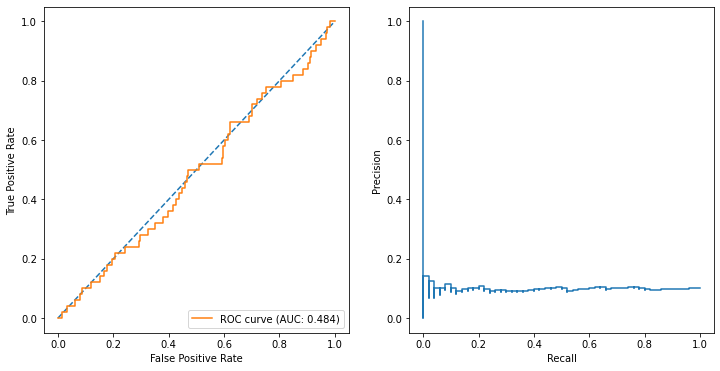

              precision    recall  f1-score   support

           0      0.855     0.118     0.207       450
           1      0.094     0.820     0.168        50

    accuracy                          0.188       500
   macro avg      0.474     0.469     0.188       500
weighted avg      0.779     0.188     0.203       500



[]

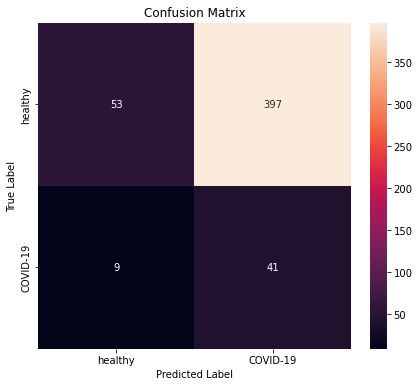

In [64]:
# choose best model from cv run
model = rnd_search_cv_5.best_estimator_

# make predictions on test data
y_test_pred = model.predict(X_test)
y_test_probs = model.predict_proba(X_test)[:,1]

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC: {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot()